# Generate particles at defined locations

Sometime it is useful to generate images where the particle locations are not randomly generated but set by the user:

In [1]:
import synpivimage as spi 
spi.__version__

from pprint import pprint

In [2]:
import os
import numpy as np

dataset_dir = 'example_data_dir_definedloc'

In [3]:
cfg = spi.config.SynPivConfig(
    ny=25,
    nx=40,
    bit_depth=8,
    dark_noise=0,
    image_particle_peak_count=50,
    laser_shape_factor=2,
    laser_width=2,
    noise_baseline=0,
    particle_number=10,
    particle_position_file='mypositions.txt',
    particle_size_illumination_dependency=True,
    pattern_meanx=2.0,
    pattern_meany=2.0,
    particle_size_mean=2.5,
    particle_size_std=0,
    qe=1.,
    sensitivity=1.,
    shot_noise=False)
cfg

SynPivConfig(ny=25, nx=40, bit_depth=8, noise_baseline=0.0, dark_noise=0.0, shot_noise=False, sensitivity=1.0, qe=1.0, particle_number=10, particle_size_mean=2.5, particle_size_std=0.0, pattern_meanx=2.0, pattern_meany=2.0, laser_width=2.0, laser_shape_factor=2, image_particle_peak_count=50, fill_ratio_x=1.0, fill_ratio_y=1.0, particle_position_file='mypositions.txt', particle_size_illumination_dependency=True, square_image=False)

In [4]:
CFGs = spi.ConfigManager([cfg], )
CFGs

<ConfigManager (1 configurations)>

In [5]:
hdf_filename = CFGs.to_hdf(dataset_dir, nproc=1, overwrite=True)

Writing 1 dataset into 1 HDF5 file(s). This may take a while...


100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.00cfg dict/s]

Processing standard names...
... done.


In [6]:
import h5rdmtoolbox as h5tbx
h5tbx.__version__

import matplotlib
import matplotlib.pyplot as plt

Text(0.5, 1.0, '')

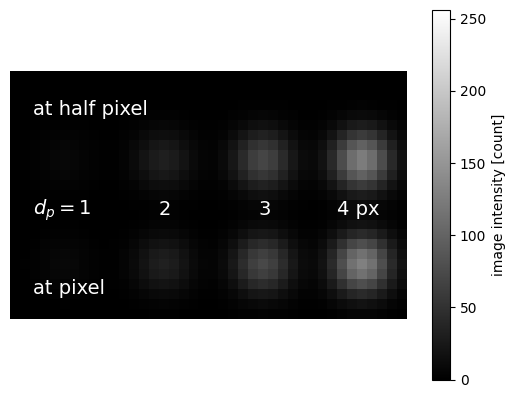

In [7]:
# with h5tbx.File(hdf_filename[0]) as h5:
    # pprint(h5.distinct('standard_name'))
    # h5.find_one({'standard_name': 'synthetic_particle_image'})[:].plot(cmap='gray',norm=matplotlib.colors.LogNorm(), vmin=1, vmax=2**8)
plt.figure()
h5tbx.database.FileDB(hdf_filename[0]).find_one({'standard_name': 'synthetic_particle_image'})[:].plot(cmap='gray', vmax=2**8)
plt.text(1.8,10,'$d_p=1$', color='white', size=14)
plt.text(14.5,10,'2', color='white', size=14)
plt.text(24.5,10,'3', color='white', size=14)
plt.text(32.5,10,'4 px', color='white', size=14)
plt.text(1.8, 2, 'at pixel', color='white', size=14)
plt.text(1.8, 20, 'at half pixel', color='white', size=14)
plt.axis('off')
plt.gca().set_aspect(1)
plt.title('')

The particle size is defined as $2\sigma^2$ and the shape is described by $I(x,y) = I_0 ~ e^{-\frac{(x-x0)^2+(y-y0)^2}{2\sigma^2}}$

Let's check if this is true for the code. We will take the "4px-particle" at the lower right of the image and fit the above gaussian to it

In [8]:
import scipy

In [9]:
sigma=2
psize = sigma*2
max_part_count = np.pi / 8 * psize ** 2 * sigma**2 * (scipy.special.erf(0.5/np.sqrt(2)/sigma)-scipy.special.erf(-0.5/np.sqrt(2)/sigma))**2

# I0 is 1 at laser mid location
intensity_factor = 200 / max_part_count

In [10]:
intensity_factor

51.048170470347166

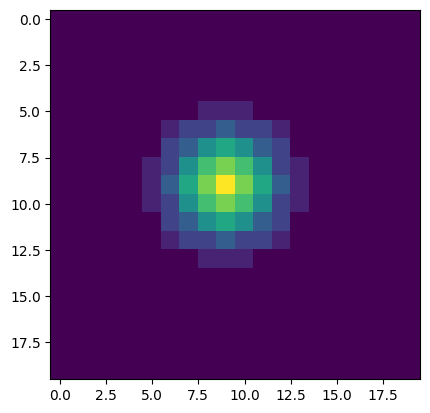

guess for psize: 1.9431351400420611


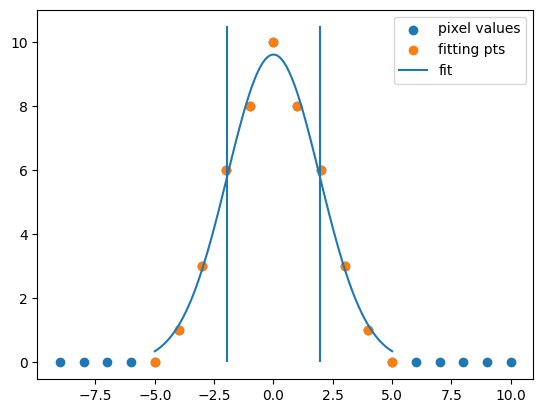

In [11]:
cfg_single_particle = spi.config.SynPivConfig(
    ny=20,
    nx=20,
    bit_depth=8,
    dark_noise=0,
    image_particle_peak_count=10,
    laser_shape_factor=2,
    laser_width=2,
    noise_baseline=0,
    particle_number=10,
    particle_size_illumination_dependency=True,
    particle_size_mean=4,
    particle_size_std=0,
    pattern_meanx=2.,
    pattern_meany=2.,
    fill_ratio_x=1.0,
    fill_ratio_y=1.0,
    qe=1.,
    sensitivity=1.,
    shot_noise=False)
cfg_single_particle

img, _, _ = spi.generate_image(
    cfg_single_particle,
    particle_data=spi.ParticleInfo(x=9,y=9,z=0,size=4)
)

plt.figure()
plt.imshow(img)
plt.show()

pixel_values = img[:, 9]
ix = np.arange(0, 20, 1)
x0 = 9
plt.figure()
plt.scatter(ix-x0, pixel_values, label='pixel values')

def gauss(x, I0, sigma):
    """Simple 1D form. psize=2*sigma. We know that x0=9"""
    x0 = 9
    return I0*np.exp(-((x-x0)**2)/(2*sigma**2))


from scipy.optimize import curve_fit
n_pts = 5
popt, pcov = curve_fit(gauss, ix[x0-n_pts:x0+n_pts+1], pixel_values[x0-n_pts:x0+n_pts+1])
plt.scatter(ix[x0-n_pts:x0+n_pts+1]-x0, pixel_values[x0-n_pts:x0+n_pts+1],
           label='fitting pts')
ix_interp = np.linspace(x0-n_pts, x0+n_pts, 100)
plt.plot(ix_interp-x0, gauss(ix_interp, *popt), label='fit')
# plt.plot(ix, gauss(ix, 180, 4/np.sqrt(2*np.log(2))/2), label='sigma=2')
_, sigma = popt
print('guess for psize:', sigma)
ymax =  plt.gca().get_ylim()[1]
plt.vlines(-sigma, 0, ymax)
plt.vlines(sigma, 0, ymax)
_ = plt.legend()
plt.show()

In [12]:
4/np.sqrt(2*np.log(2))

3.3972872011520763

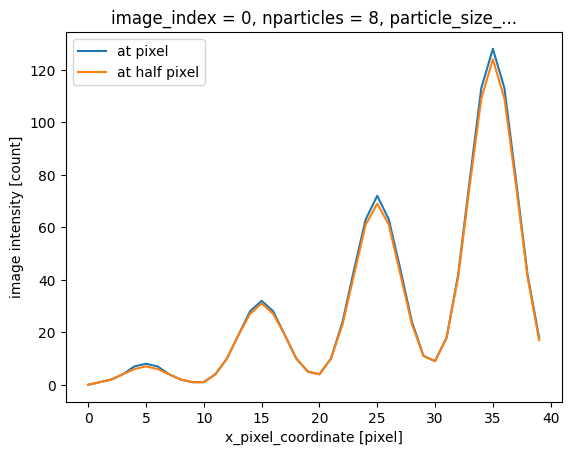

In [13]:
# with h5tbx.H5File(hdf_filename[0]) as h5:
h5tbx.database.FileDB(hdf_filename[0]).find_one({'standard_name': 'synthetic_particle_image'})[0,5,:].plot(label='at pixel')
h5tbx.database.FileDB(hdf_filename[0]).find_one({'standard_name': 'synthetic_particle_image'})[0,15,:].plot(label='at half pixel')
plt.legend()

In [14]:
np.sqrt((512*10**(-9)*2.44*5.6*8)**2+(1*10**(-6)*8)**2)

5.6536610868087385e-05

In [15]:
np.sqrt((512*10**(-9)*2.44*5.6*8)**2)

5.5967744e-05

In [16]:
np.sqrt((1*10**(-6)*8)**2)

8e-06